# E19-Unet Concatenate Models
---
**LV2-concatenate**
- LV1-Buildings, LV1-Roads 모델을 합쳐 하나의 모델을 생성한다.
- 이때, 사용된 모델의 trainable=False로 하고, weight는 이전 실험에서 얻어진 best model을 사용한다.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import math
import numpy as np
import tensorflow as tf
import keras
import h5py
from pathlib import Path

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import cv2
import math
from tqdm import tqdm

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import albumentations as A

import seaborn as sns
sns.set(style='white')
sns.set_context('paper')

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [2]:
import tensorflow as tf
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')

            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")

init_gpu()

1 Physical GPUs, 1 Logical GPUs




In [3]:
FILE_PATH = '/home/aiffel-dj1/workspace/Hackerton/workspace/Model/data/LV2_PNG_DATASET_OSM.h5'
BASE_TARIN_DIR = "/train"
TRAIN_IMG_PATH = f'{Path(BASE_TARIN_DIR)}/img'
TRAIN_LABEL_PATH = f'{Path(BASE_TARIN_DIR)}/label'
TRAIN_SPLIT_DIR = f'{Path(BASE_TARIN_DIR)}/split'  
TRAIN_SPLIT_IMG_PATH = f'{Path(BASE_TARIN_DIR)}/split/img'           
TRAIN_SPLIT_LABEL_PATH = f'{Path(BASE_TARIN_DIR)}/split/label'                                                                                                                         

BASE_VAL_DIR = "/val"
VAL_IMG_PATH = f'{Path(BASE_VAL_DIR)}/img'
VAL_LABEL_PATH = f'{Path(BASE_VAL_DIR)}/label'
VAL_SPLIT_DIR = f'{Path(BASE_VAL_DIR)}/split'  
VAL_SPLIT_IMG_PATH = f'{Path(BASE_VAL_DIR)}/split/img'           
VAL_SPLIT_LABEL_PATH = f'{Path(BASE_VAL_DIR)}/split/label'  

BASE_TEST_DIR = "/test"
TEST_IMG_PATH = f'{Path(BASE_TEST_DIR)}/img'
TEST_LABEL_PATH = f'{Path(BASE_TEST_DIR)}/label'
TEST_SPLIT_DIR = f'{Path(BASE_TEST_DIR)}/split'  
TEST_SPLIT_IMG_PATH = f'{Path(BASE_TEST_DIR)}/split/img'           
TEST_SPLIT_LABEL_PATH = f'{Path(BASE_TEST_DIR)}/split/label'  

IMAGE_SIZE = 1024
IMG_CHANNELS = 3

COLOR_MAP = [
    (165, 42, 42),
    (0, 192, 0),
    (255,255,255)
]

## Segmentation_model

In [45]:
BACKBONE = 'efficientnetb3'
n_classes = 1
activation = 'sigmoid'
model_1 = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
model_1.load_weights('/home/aiffel-dj1/workspace/Hackerton/workspace/Model/trained_model/E16/E16_1_best_model.h5')
model_1.trainable = False

model_2 = sm.Unet(BACKBONE, classes=n_classes, input_shape=(None,None,4), activation=activation, encoder_weights=None)
model_2.load_weights('/home/aiffel-dj1/workspace/Hackerton/workspace/Model/trained_model/E11/E11_4_best_model.h5')
model_2.trainable = False

model_1._name='Unet_Building_Seg'
model_1_wrapper = tf.keras.Sequential([
  model_1
])

model_2._name='Unet_Road_Seg'
model_2_wrapper = tf.keras.Sequential([
  model_2
])

combined = tf.keras.layers.concatenate([model_1_wrapper.output, model_2_wrapper.output])
model = Model(inputs=[model_1_wrapper.input, model_2_wrapper.input], outputs=combined)

In [46]:
dice_loss = sm.losses.DiceLoss()
n_classes = 2
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),
              loss=total_loss,
              metrics=metrics)
  
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Unet_Building_Seg_input (InputL [(None, None, None,  0                                            
__________________________________________________________________________________________________
Unet_Road_Seg_input (InputLayer [(None, None, None,  0                                            
__________________________________________________________________________________________________
Unet_Building_Seg (Functional)  (None, None, None, 1 17867833    Unet_Building_Seg_input[0][0]    
__________________________________________________________________________________________________
Unet_Road_Seg (Functional)      (None, None, None, 1 17868193    Unet_Road_Seg_input[0][0]        
____________________________________________________________________________________________

In [47]:
model.input_shape, model.output_shape

([(None, None, None, 3), (None, None, None, 4)], (None, None, None, 2))

## Funtions

### Split

In [7]:
import random

def get_slice_pos(split_cnt, slice_type='sliding', stride_size=192, input_size=256, img_size=1024):
    pts = []
    
    if slice_type == 'sliding':
        n = math.sqrt(split_cnt)
        for slice_pos in range(split_cnt):
            pos_i = int(math.floor(slice_pos / n))
            pos_j = int(slice_pos % int(n))
            
            x = stride_size * pos_i
            y = stride_size * pos_j
            
            pts.append((x, x+input_size, y, y+input_size))
            
    elif slice_type =='crop':
        random.seed(2)
        get_random_point = lambda: random.randint(0, img_size-input_size)
        
        for _ in range(split_cnt):
            x = get_random_point()
            y = get_random_point()
            pts.append((x, x+input_size, y, y+input_size))
            
    return pts

In [8]:
def split_png(img, pts):
    if len(img.shape) == 3:
        sub_imgs = [img[x0:x1, y0:y1, :] for x0, x1, y0, y1 in pts]
    elif len(img.shape) == 2:
        sub_imgs = [img[x0:x1, y0:y1] for x0, x1, y0, y1 in pts]
    return sub_imgs

In [9]:
def save_png_imgs_labels(dataset, i, imgs, labels):
    for img, label in zip(imgs, labels):
        dataset['img'][i, ...] = img
        dataset['label'][i, ...] = label
        i += 1
    return i

In [10]:
def filtering(imgs, labels, threshold=1, img_size=256):
    """ label을 조건에 맞게 필터링해주는 함수
    라벨에서 1이 threshold 초과인 것들만을 필터링하여 반환합니다.
    하지만, threshold 미만은 모든 데이터를 지우는 것은 데이터 학습의 효율을 떨어뜨릴 수 있으므로,
    이 과정에 확률을 넣어 (면적 차지 비율)% 확률로 threshold 미만의 데이터가 필터링 되지 않도록 한다.
    
    Args:
        imgs (list): 잘려진 이미지 목록, labels와 쌍을 이룬다.
        labels (list): 잘려진 라벨 목록, imgs와 쌍을 이룬다.
        threshold (float): 라벨에 포한된 1의 비율(%)이 threshold 이하인 것은 필터링되고 초과인 것들만 남게된다.

    Returns:
        filtered_imgs (list): 필터링된 이미지
        filtered_labels (list): 필터링된 라벨
    """
    rand = lambda x: np.random.choice([0, 1], 1, p=[1-(x/100), x/100])[0]

    label_areas = np.array([label.sum() for label in labels])
    rates = label_areas / (img_size * img_size) * 100
    filter_mask = [True if rate > threshold else rand(rate) for rate in rates]
    
    filtered_imgs = [img for img, mask in zip(imgs, filter_mask) if mask]
    filtered_labels = [label for label, mask in zip(labels, filter_mask) if mask]
    return filtered_imgs, filtered_labels

In [11]:
def split_filtering_save(filtering_fun, FILE_PATH, BASE_DIR, IMG_PATH, LABEL_PATH, 
                         COLOR, img_size=256, split_cnt=25, threshold=1):
    """ label을 조건에 맞게 필터링해주는 함수
    라벨에서 1이 threshold 초과인 것들만을 필터링하여 반환합니다.
    
    Args:
        imgs (list): 잘려진 이미지 목록, labels와 쌍을 이룬다.
        labels (list): 잘려진 라벨 목록, imgs와 쌍을 이룬다.
        threshold (float)
            - 라벨에 포한된 1의 비율(%)이 threshold 이하인 것은 필터링되고 초과인 것들만 남게된다.
            - 만약 0이 주어진다면 모든 이미지를 필터링 없이 저장한다.

    Returns:
        filtered_imgs (list): 필터링된 이미지
        filtered_labels (list): 필터링된 라벨
    """
    start_time = time.time()
    with h5py.File(FILE_PATH, "a") as f:
        # create split dataset ex. FILE[train][split][img], FILE[train][split][label]
        size = f[IMG_PATH].shape[0] * split_cnt
        if 'split' in f[BASE_DIR].keys(): del f[BASE_DIR]['split']
        f[BASE_DIR].create_group('split')
        img_ds = f[BASE_DIR]['split'].create_dataset('img', (size, img_size, img_size, 3), np.uint8, maxshape=(size, img_size, img_size, 4))
        lable_ds = f[BASE_DIR]['split'].create_dataset('label', (size, img_size, img_size), np.float32, maxshape=(size, img_size, img_size))
        
        if threshold > 0:
            pts = get_slice_pos(split_cnt, 'crop')
        else:
            pts = get_slice_pos(split_cnt, 'sliding')
                
        sub_idx = 0
        for i in tqdm(range(f[IMG_PATH].shape[0])):
            
            
            # split img with pts(left-top points)
            sub_imgs = split_png(f[IMG_PATH][i], pts)
            
            # extract binary mask from label
            mask = (f[LABEL_PATH][i] == COLOR)
            mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
            
             # split mask with pts
            sub_labels = split_png(mask, pts)
            
            # filtering labels.
            # after this, the label ratio of less than threshold is filtered out.
            filtered_imgs, filtered_labels = filtering_fun(sub_imgs, sub_labels, threshold=threshold, img_size=img_size)
            
            # save imgs and labels in split dataset
            filted_img_size = len(filtered_imgs)
            img_ds[sub_idx:sub_idx+filted_img_size, ...] = filtered_imgs
            lable_ds[sub_idx:sub_idx+filted_img_size, ...] = filtered_labels
            sub_idx += filted_img_size
            
        # resize dataset
        img_ds.resize((sub_idx, img_size, img_size, 3))
        lable_ds.resize((sub_idx, img_size, img_size))

### Utility

In [12]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(10, 5))
    
    for i, (name, image) in enumerate(images.items()):
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(' '.join(name.split('_')).title())
        axs[i].imshow(image)
        
    plt.tight_layout()
    plt.show()

In [13]:
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

### Split

## Dataset

In [14]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation():
    train_transform = [
        A.RandomRotate90(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [15]:
class SatelliteGenerator(tf.keras.utils.Sequence):
    '''
    ref: https://github.com/AIFFEL-FREESIA/Model/blob/master/Unet_building_256_2.ipynb
    SatelliteGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    '''
    def __init__(self, 
                 filepath,
                 x_path,
                 y_path,
                 batch_size=8,
                 augmentation=None, 
                 preprocessing=None,
                 is_train=True):
        
        self.filepath = filepath
        self.x_path = x_path
        self.y_path = y_path
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        self.size = 0
        with h5py.File(self.filepath, 'r') as f:
            self.size = f[x_path].shape[0]
            
        self.batch_size = batch_size
        self.is_train = is_train
    
    def __len__(self):
        return math.ceil(self.size / self.batch_size)

    def __getitem__(self, index):
        with h5py.File(self.filepath, 'r') as f:
            images = f[self.x_path][index*self.batch_size : (index + 1)*self.batch_size]
            masks = f[self.y_path][index*self.batch_size : (index + 1)*self.batch_size]
            res = [(img, mask) for img, mask in zip(images, masks)]

            if self.augmentation:
                res = [self.augmentation(image=img, mask=mask) for img, mask in res]
                res = [(r['image'], r['mask']) for r in res]
            if self.preprocessing:
                res = [self.preprocessing(image=img, mask=mask) for img, mask in res]
                res = [(r['image'], r['mask']) for r in res]
            
            images = np.array([img for img, _ in res ])
            images_building = np.array([img[:,:,:3] for img in images ])
            masks = np.array([mask for _, mask in res ])
            masks = np.array([mask[:,:,:2] for mask in masks ])
            
            return [images_building, images], masks

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(self.size)
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        
        return self.indexes

In [16]:
def get_datagenerator(BATCH_SIZE=8, BACKBONE='efficientnetb3'):
    # Dataset for train images
    preprocess_input = sm.get_preprocessing(BACKBONE)
    train_datagenerator = SatelliteGenerator(
        FILE_PATH,
        TRAIN_SPLIT_IMG_PATH,
        TRAIN_SPLIT_LABEL_PATH,
        batch_size=BATCH_SIZE,
        augmentation=get_training_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
        is_train=True
    )

    # Dataset for validation image
    valid_datagenerator = SatelliteGenerator(
        FILE_PATH,
        VAL_SPLIT_IMG_PATH, 
        VAL_SPLIT_LABEL_PATH, 
        batch_size=BATCH_SIZE,
        augmentation=get_validation_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
        is_train=False
    )

    return train_datagenerator, valid_datagenerator

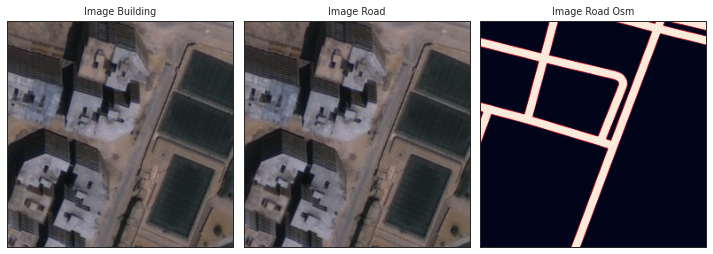

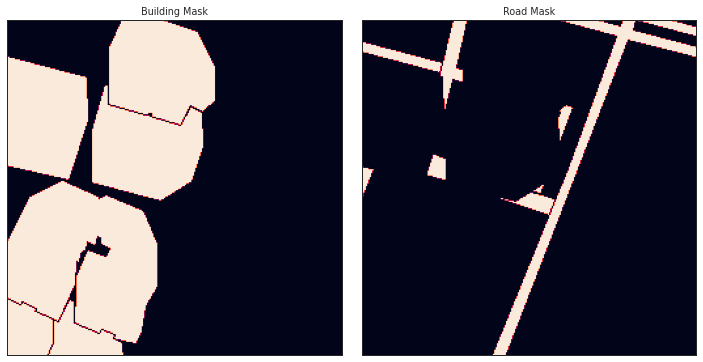

In [17]:
# Lets look at augmented data we have
dataset = SatelliteGenerator(
    FILE_PATH,
    VAL_SPLIT_IMG_PATH,
    VAL_SPLIT_LABEL_PATH, 
    augmentation=get_training_augmentation()
)

dataset_aug = SatelliteGenerator(
    FILE_PATH,
    VAL_SPLIT_IMG_PATH,
    VAL_SPLIT_LABEL_PATH, 
    augmentation=get_training_augmentation())

preprocess_input = sm.get_preprocessing('efficientnetb3')
dataset_aug_pre = SatelliteGenerator(
    FILE_PATH,
    VAL_SPLIT_IMG_PATH,
    VAL_SPLIT_LABEL_PATH,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)

idx = 10
[image_b, image_r], mask = dataset[idx] # get some sample
# image_aug, mask_aug = dataset_aug[idx]
# image_aug_pre, mask_aug_pre = dataset_aug_pre[idx]

visualize(
    image_building=image_b[0], 
    image_road=image_r[0][:,:,:3],
    image_road_osm=image_r[0][:,:,3]
)

visualize(
    building_mask=mask[0][:,:,0],
    road_mask=mask[0][:,:,1]
)

In [48]:
lr = 1e-4
BATCH_SIZE = 8
EPOCHS=100
optim = keras.optimizers.Adam(lr=lr)
train_datagenerator, valid_datagenerator = get_datagenerator(BATCH_SIZE=BATCH_SIZE)

In [49]:
log_dir = f"logs/E18/E18-1"
MODEL_PATH = '/home/aiffel-dj1/workspace/Hackerton/workspace/Model/trained_model/E18_1_best_model.h5'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [
    keras.callbacks.ModelCheckpoint(MODEL_PATH, save_weights_only=True, save_best_only=True, mode='min', monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    tensorboard_callback,
    keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
]

In [50]:
history = model.fit(
    train_datagenerator, 
    steps_per_epoch=len(train_datagenerator), 
    epochs=1, 
    callbacks=callbacks, 
    validation_data=valid_datagenerator, 
    validation_steps=len(valid_datagenerator))

836/836 [==============================] - 129s 136ms/step - loss: 0.3056 - iou_score: 0.6199 - f1-score: 0.7459 - val_loss: 0.3195 - val_iou_score: 0.6057 - val_f1-score: 0.7354


In [51]:
import random

def get_slice_pos(split_cnt, slice_type='sliding', stride_size=192, input_size=256, img_size=1024):
    pts = []
    
    if slice_type == 'sliding':
        n = math.sqrt(split_cnt)
        for slice_pos in range(split_cnt):
            pos_i = int(math.floor(slice_pos / n))
            pos_j = int(slice_pos % int(n))
            
            x = stride_size * pos_i
            y = stride_size * pos_j
            
            pts.append((x, x+input_size, y, y+input_size))
            
    elif slice_type =='crop':
        random.seed(2)
        get_random_point = lambda: random.randint(0, img_size-input_size)
        
        for _ in range(split_cnt):
            x = get_random_point()
            y = get_random_point()
            pts.append((x, x+input_size, y, y+input_size))
            
    return pts

pts = get_slice_pos(25, 'sliding')

In [164]:
def merge_img(sub_imgs, pts):
    merged = np.zeros((1024, 1024, 3))
    seg_map = np.zeros((1024, 1024))

    for i in range(len(sub_imgs)):
        bg = np.where(sub_imgs[i] <= .5, 0.5, 0)
        bg = np.logical_and(bg[:,:,0], bg[:,:,1])
        sub_imgs[i] = np.stack([sub_imgs[i][:,:,0], sub_imgs[i][:,:,1], bg], axis=-1)
    
    for i, (x0, x1, y0, y1) in enumerate(pts):
        sub_a = merged[x0:x1, y0:y1, :]
        sub_b = sub_imgs[i]
        added = np.where(sub_a > sub_b, sub_a, sub_b)
        
        reduced = np.argmax(added, axis=-1)
        merged[x0:x1, y0:y1, :] = added
        seg_map[x0:x1, y0:y1] = reduced
    return seg_map

In [114]:
def inference(model, img, crop_pts):
    preprocessing = A.Compose([
        A.Lambda(image=sm.get_preprocessing(BACKBONE)),
    ])
    
    sub_imgs = split_png(img, crop_pts)
    sub_imgs = [preprocessing(image=img)['image'] for img in sub_imgs]
    sub_imgs = [np.expand_dims(img, axis=0) for img in sub_imgs]
    
    predict_imgs = [model.predict((img[:,:,:,:3], img)) for img in sub_imgs]
    predict_imgs = [predict.squeeze() for predict in predict_imgs]
    
    merged_img = merge_img(predict_imgs, crop_pts)
    return merged_img

In [96]:
def coloring_seg_map(seg_map):
    color_map = np.stack([seg_map,seg_map,seg_map], axis=-1)
    color_map = np.where(color_map == 0, COLOR_MAP[0], color_map)
    color_map = np.where(color_map == 1, COLOR_MAP[1], color_map)
    color_map = np.where(color_map == 2, COLOR_MAP[2], color_map).astype(np.uint8)
    return color_map

In [170]:
def show_inference(model, pts):
    with h5py.File(FILE_PATH, "r") as f:
        for idx in range(len(f[VAL_IMG_PATH])):
            img = f[VAL_IMG_PATH][idx]
            
            predicted = inference(model, img, pts)
            predicted = coloring_seg_map(predicted)
            visualize(
                image=img[:,:,:3],
                ground_truth=f[VAL_LABEL_PATH][idx],
                predicted=predicted,
            )

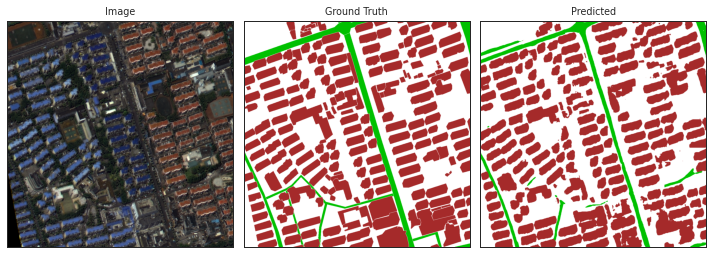

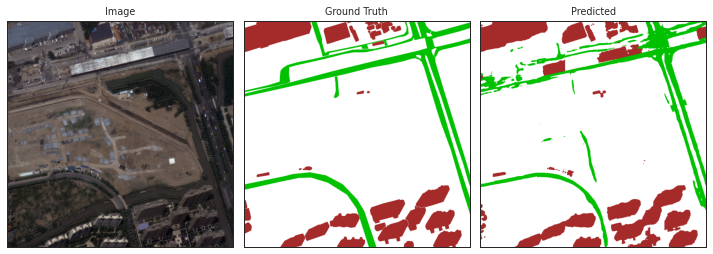

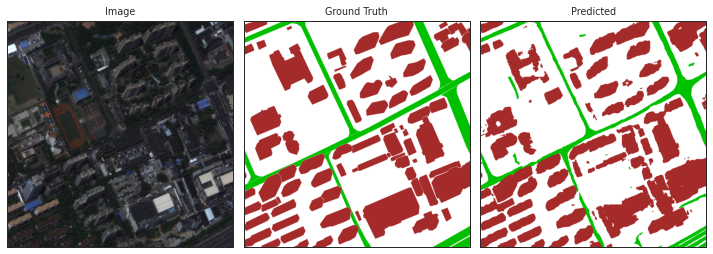

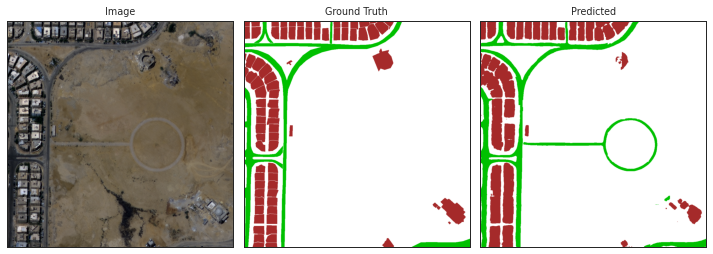

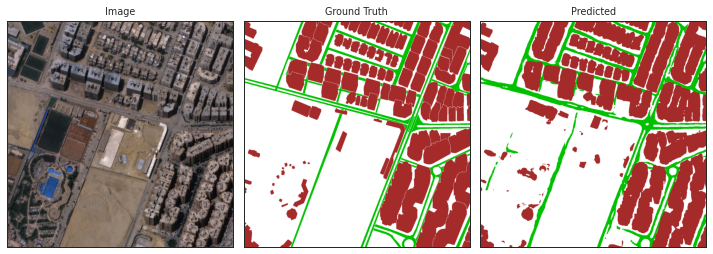

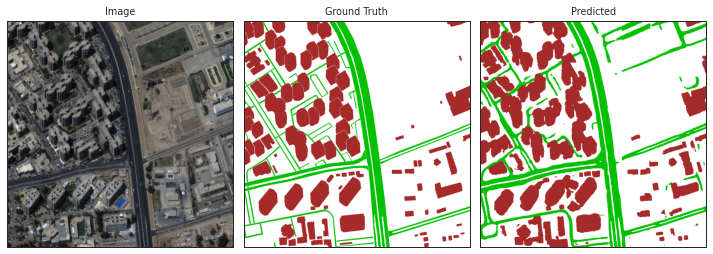

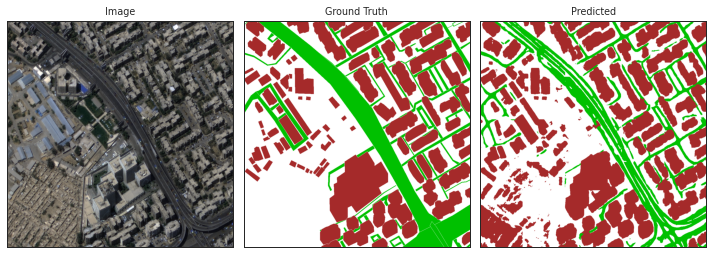

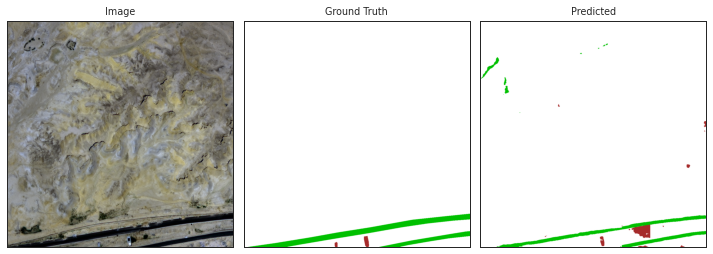

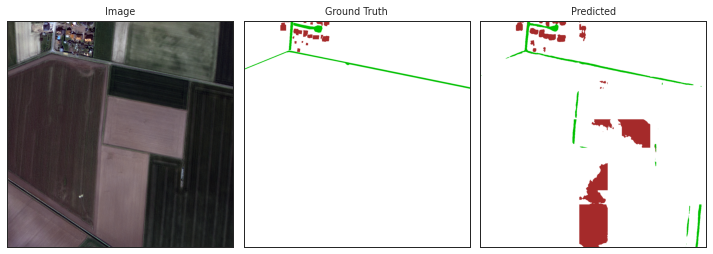

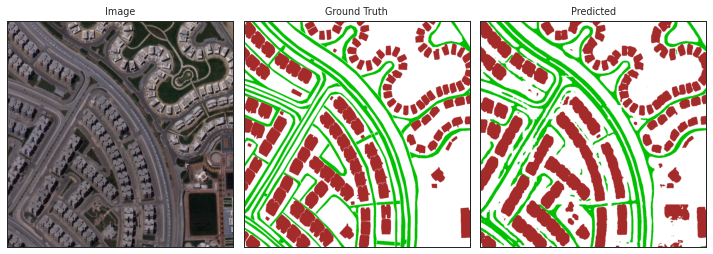

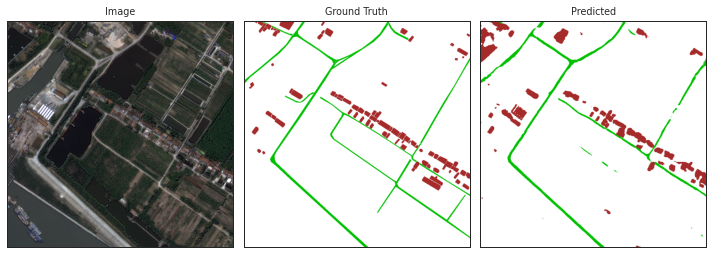

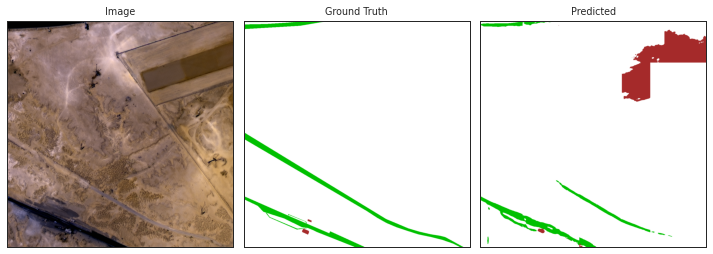

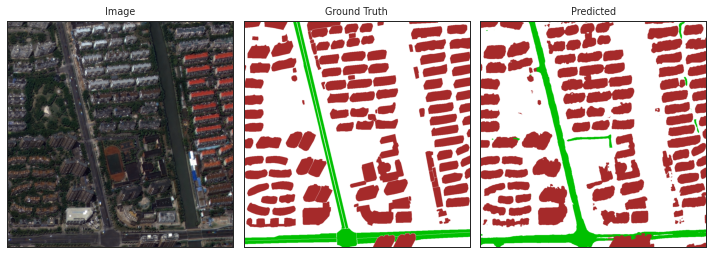

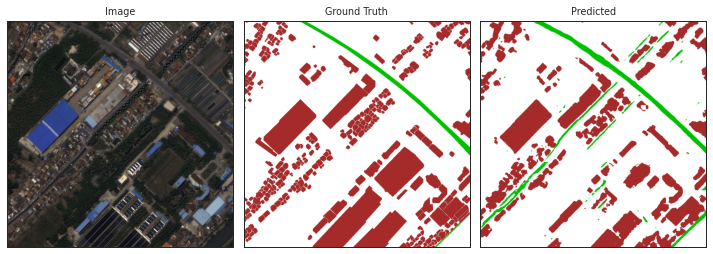

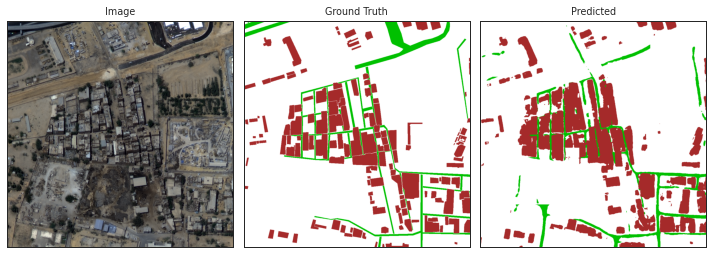

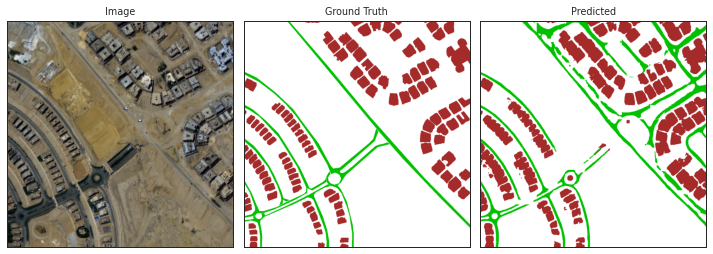

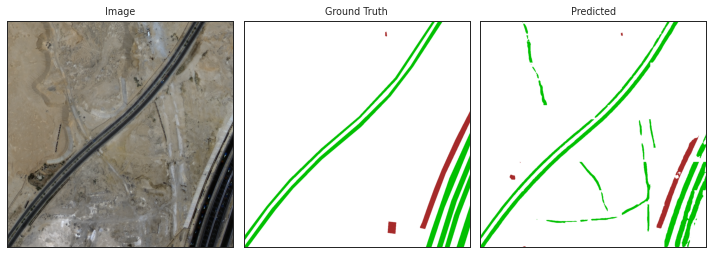

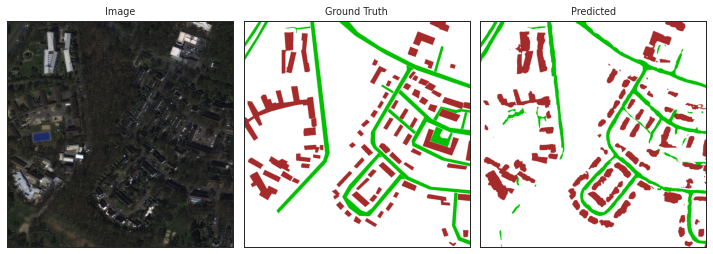

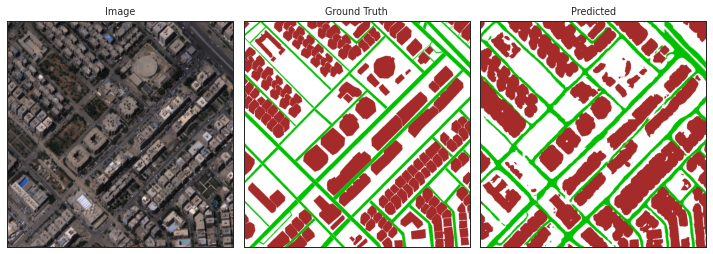

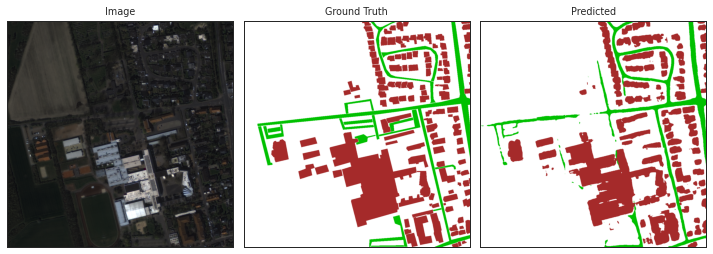

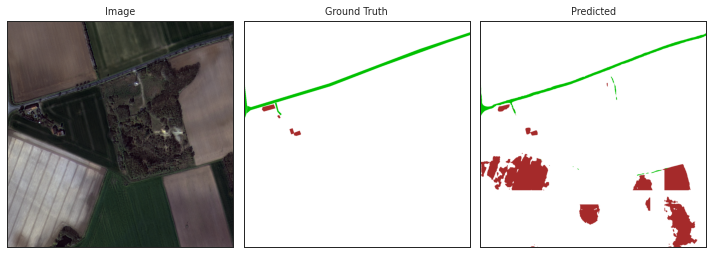

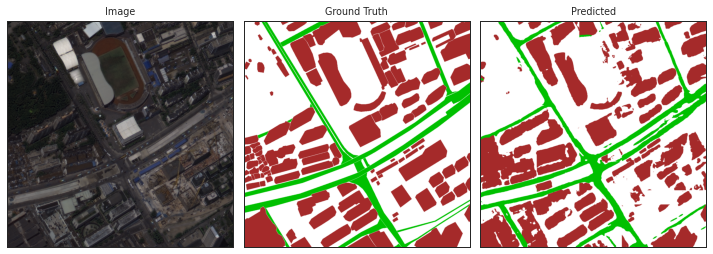

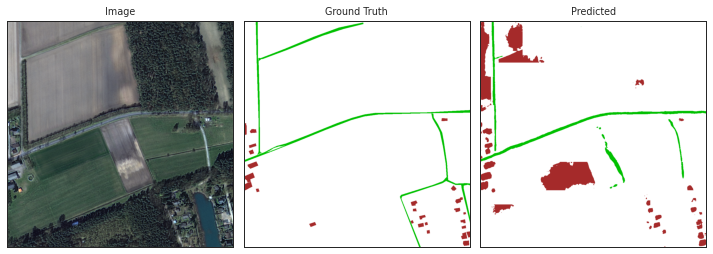

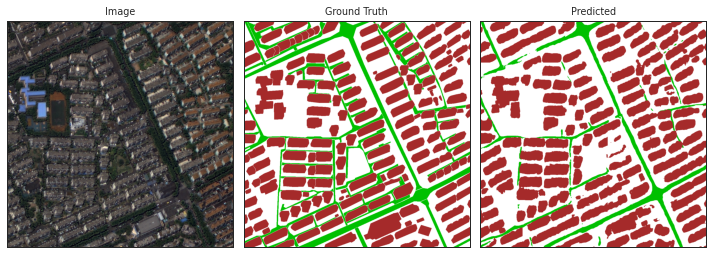

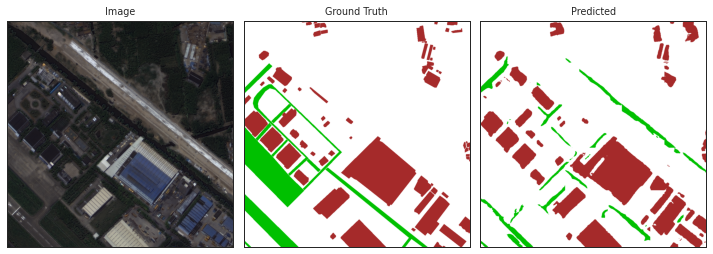

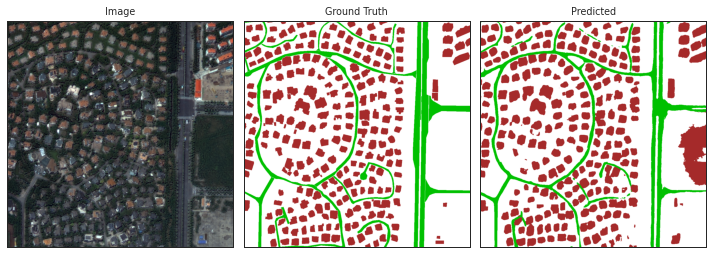

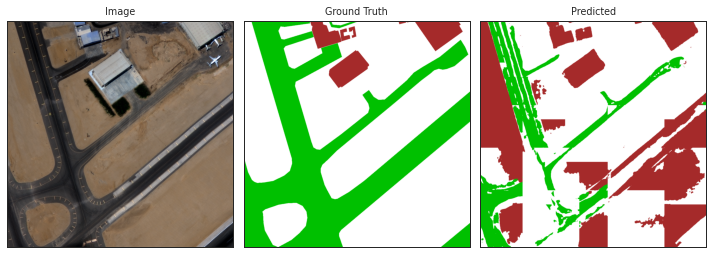

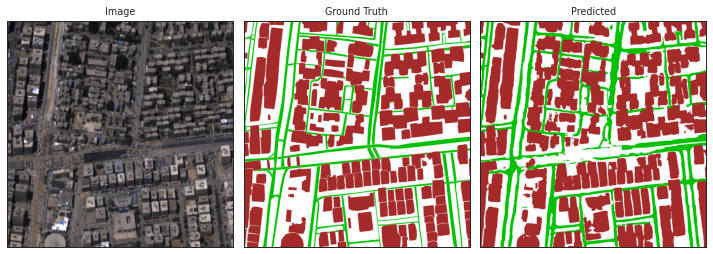

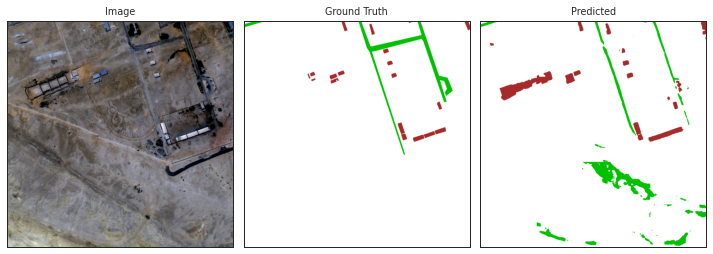

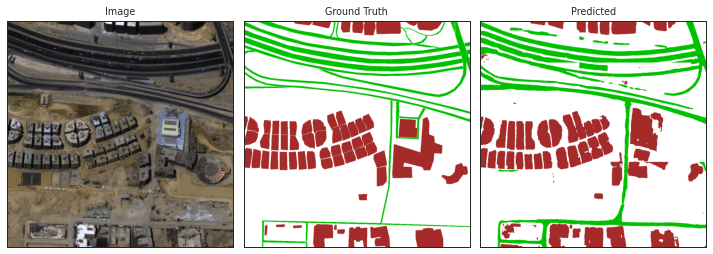

In [171]:
show_inference(model, pts)